# SIR model: inverse problem
## A PINN approach

In this notebook, we will solve the inverse problem of the SIR model using a Physics-Informed Neural Network (PINN). The goal is to estimate the infection rate $\beta$ from the observed data of the infected population. To do this, we will train a PINN model, where we compute the residuals of the differential equation system with initial conditions and the data loss simultaneously.

The SIR model is governed by the following set of ordinary differential equations (ODEs):

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

## Configuration

In [107]:
import os
import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Union
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt

# Create directories
figures_dir = "figures"
data_dir = "data"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

## Module's components

In [108]:
class Square(nn.Module):
    """A module that squares its input element-wise."""
    @staticmethod
    def forward(x):
        return torch.square(x)


def create_mlp(layers_dims, activation, output_activation):
    """Create a multi-layer perceptron with specified architecture."""
    layers = []
    for i in range(len(layers_dims) - 1):
        layers.append(nn.Linear(layers_dims[i], layers_dims[i + 1]))
        if i < len(layers_dims) - 2:
            layers.append(activation)
    layers.append(output_activation)

    net = nn.Sequential(*layers)

    for layer in net:
        if isinstance(layer, nn.Linear):
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    return net

## Module's configuration

In [109]:
@dataclass
class SIRConfig:
    """Configuration for SIR PINN model and training."""
    # Model parameters
    N: float = 1.0
    delta: float = 0.2
    initial_beta: float = 0.5
    
    # Neural network architecture
    hidden_layers: List[int] = field(default_factory=lambda: 4 * [50])
    activation: str = 'tanh'
    output_activation: str = 'square'
    
    # Initial conditions
    initial_conditions: List[float] = field(default_factory=lambda: [1.0 - 1e-6, 1e-6, 0.0])
    
    # Training parameters
    learning_rate: float = 1e-3
    batch_size: int = 100
    max_epochs: int = 50
    
    # Scheduler parameters
    scheduler_factor: float = 0.5
    scheduler_patience: int = 100
    scheduler_threshold: float = 0.01
    scheduler_min_lr: float = 1e-6
    
    # Early stopping
    early_stopping_patience: int = 200
    
    # Loss weights
    pde_weight: float = 0.1
    ic_weight: float = 0.45
    data_weight: float = 0.45
    
    # Dataset parameters
    time_domain: Tuple[float, float] = (0.0, 90.0)
    collocation_points: int = 6000
    
    # Logging
    log_every_n_steps: int = 40

## Dataset creation

In [110]:
class SIRDataset(Dataset):
    """Dataset for SIR PINN training."""
    def __init__(
        self, 
        t_obs: np.ndarray, 
        i_obs: np.ndarray, 
        time_domain: Tuple[float, float] = (0.0, 90.0), 
        n_collocation: int = 6000
    ):
        """
        Initialize dataset with observation points and random collocation points.
        
        Args:
            t_obs: Observation time points
            i_obs: Observed infected population at each time point
            time_domain: (t_min, t_max) time range
            n_collocation: Number of random collocation points to generate
        """
        self.t_obs = torch.tensor(t_obs, dtype=torch.float32).reshape(-1, 1)
        self.i_obs = torch.tensor(i_obs, dtype=torch.float32).reshape(-1, 1)
        
        # Generate random collocation points with log-uniform distribution
        t_min, t_max = time_domain
        rand_t = np.expm1(np.random.uniform(np.log1p(t_min), np.log1p(t_max), n_collocation))
        self.t_collocation = torch.tensor(rand_t, dtype=torch.float32).reshape(-1, 1)
        
        self.t_combined = torch.cat([self.t_obs, self.t_collocation], dim=0)
        
        # Create a mask to identify observation points
        self.is_obs = torch.zeros(len(self.t_combined), dtype=torch.bool)
        self.is_obs[:len(self.t_obs)] = True
        
        # Create target values for all points (observations have actual values, collocation are zeros)
        self.i_targets = torch.zeros(len(self.t_combined), 1, dtype=torch.float32)
        self.i_targets[:len(self.t_obs)] = self.i_obs
        
    def __len__(self):
        return len(self.t_combined)
    
    def __getitem__(self, idx):
        return {
            't': self.t_combined[idx],
            'is_obs': self.is_obs[idx],
            'i_target': self.i_targets[idx]
        }

## Module definition

In [111]:
class SIRPINN(pl.LightningModule):
    """Physics-Informed Neural Network for SIR model parameter identification."""
    
    def __init__(self, config: SIRConfig):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        
        # Set activation functions
        activation_map = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'sigmoid': nn.Sigmoid(),
            'selu': nn.SELU()
        }
        
        output_activation_map = {
            'square': Square(),
            'softplus': nn.Softplus(),
            'identity': nn.Identity()
        }
        
        activation = activation_map.get(config.activation, nn.Tanh())
        output_activation = output_activation_map.get(config.output_activation, Square())
        
        # Define network architecture
        layers_dims = [1] + config.hidden_layers + [1]
        
        # Create networks for S and I compartments
        self.net_S = create_mlp(layers_dims, activation, output_activation)
        self.net_I = create_mlp(layers_dims, activation, output_activation)
        
        # Initialize learnable parameter beta
        self.beta = nn.Parameter(torch.tensor(config.initial_beta, dtype=torch.float32))
        
        # Fixed parameters
        self.N = config.N
        self.delta = config.delta
        
        # Loss function
        self.loss_fn = nn.MSELoss()
        
        # For tracking metrics
        self.beta_history = []
        
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to compute S, I, R values at time t.
        
        Args:
            t: Time points tensor of shape [batch_size, 1]
            
        Returns:
            Tensor of shape [batch_size, 3] with [S, I, R] values
        """
        S = self.net_S(t)
        I = self.net_I(t)
        R = self.N - S - I
        
        return torch.cat([S, I, R], dim=1)
        
    @torch.enable_grad()
    @torch.inference_mode(False)
    def compute_ode_residuals(self, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute residuals of the SIR ODEs using automatic differentiation.
        
        Args:
            t: Time points tensor of shape [batch_size, 1]
            
        Returns:
            Tuple of residual tensors (res_S, res_I)
        """
        t_tensor = t.clone().detach().requires_grad_(True)
    
        S = self.net_S(t_tensor)
        I = self.net_I(t_tensor)
        
        dS_dt = torch.autograd.grad(
            S, t_tensor, grad_outputs=torch.ones_like(S), create_graph=True
        )[0]
        
        dI_dt = torch.autograd.grad(
            I, t_tensor, grad_outputs=torch.ones_like(I), create_graph=True
        )[0]

        
        res_S = dS_dt + self.beta * S * I
        res_I = dI_dt - self.beta * S * I + self.delta * I
        
        return res_S, res_I
    
    def pde_loss(self, t: torch.Tensor) -> torch.Tensor:
        """Compute PDE residual loss."""
        res_S, res_I = self.compute_ode_residuals(t)
        loss_S = self.loss_fn(res_S, torch.zeros_like(res_S))
        loss_I = self.loss_fn(res_I, torch.zeros_like(res_I))
        return loss_S + loss_I
    
    def ic_loss(self) -> torch.Tensor:
        """Compute initial condition loss."""
        t0 = torch.zeros(1, 1, device=self.device, dtype=torch.float32)
        ic_pred = self(t0)
        ic_true = torch.tensor(
            self.config.initial_conditions, 
            device=self.device,
            dtype=torch.float32
        ).reshape(1, 3)
        return self.loss_fn(ic_pred, ic_true)
    
    def data_loss(self, t_obs: torch.Tensor, i_obs: torch.Tensor) -> torch.Tensor:
        """Compute data fitting loss."""
        if t_obs.shape[0] == 0:  # No observations in batch
            return torch.tensor(0.0, device=self.device)
        
        i_pred = self(t_obs)[:, 1:2]  # Extract I component
        return self.loss_fn(i_pred, i_obs)
    
    def training_step(self, batch, batch_idx):
        # Extract batch data
        t = batch['t']
        is_obs = batch['is_obs']
        i_target = batch['i_target']
        
        # Split into observation and collocation points
        t_obs = t[is_obs] if is_obs.any() else torch.zeros((0, 1), device=self.device)
        i_obs = i_target[is_obs] if is_obs.any() else torch.zeros((0, 1), device=self.device)
        
        # Compute losses
        pde_loss_val = self.pde_loss(t)
        ic_loss_val = self.ic_loss()
        data_loss_val = self.data_loss(t_obs, i_obs)
        
        # Weighted sum of losses
        total_loss = (
            self.config.pde_weight * pde_loss_val +
            self.config.ic_weight * ic_loss_val +
            self.config.data_weight * data_loss_val
        )
        
        # Log metrics only every n steps
        if self.global_step % self.config.log_every_n_steps == 0:
            self.log('train/pde_loss', pde_loss_val )
            self.log('train/ic_loss', ic_loss_val)
            self.log('train/data_loss', data_loss_val)
            self.log('train/total_loss', total_loss, prog_bar=True)
            self.log('train/beta', self.beta.item(), prog_bar=True)
        
        # Track beta history
        self.beta_history.append(self.beta.item())
        
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        # Same computation as training but for validation set
        t = batch['t']
        is_obs = batch['is_obs']
        i_target = batch['i_target']
        
        t_obs = t[is_obs] if is_obs.any() else torch.zeros((0, 1), device=self.device)
        i_obs = i_target[is_obs] if is_obs.any() else torch.zeros((0, 1), device=self.device)
        
        pde_loss_val = self.pde_loss(t)
        ic_loss_val = self.ic_loss()
        data_loss_val = self.data_loss(t_obs, i_obs)
        
        total_loss = (
            self.config.pde_weight * pde_loss_val +
            self.config.ic_weight * ic_loss_val +
            self.config.data_weight * data_loss_val
        )
        
        self.log('val/pde_loss', pde_loss_val)
        self.log('val/ic_loss', ic_loss_val)
        self.log('val/data_loss', data_loss_val)
        self.log('val/total_loss', total_loss)
        
        return total_loss
    
    @torch.no_grad()
    def predict_sir(self, t):
        """Predict SIR values at specified time points."""
        t_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1).to(self.device)
        return self(t_tensor).cpu().numpy()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.config.learning_rate
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=self.config.scheduler_factor,
            patience=self.config.scheduler_patience,
            threshold=self.config.scheduler_threshold,
            min_lr=self.config.scheduler_min_lr
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/total_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

## Training definition

In [112]:
def train_sir_pinn(t_obs, i_obs, override_config=None):
    """
    Train a SIR PINN model using the provided observations.
    
    Args:
        t_obs: Observation time points
        i_obs: Observed infected proportions
        override_config: Configuration object (optional)
        
    Returns:
        Trained PINN model
    """
    if override_config is None:
        config = SIRConfig()
    else:
        config = override_config
    
    # Create dataset and dataloaders
    dataset = SIRDataset(
        t_obs=t_obs,
        i_obs=i_obs,
        time_domain=config.time_domain,
        n_collocation=config.collocation_points
    )
    
    # Split into train/validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Create model
    model = SIRPINN(config)
    
    # Setup callbacks
    callbacks = [
        # pl.callbacks.EarlyStopping(
        #     monitor='val/total_loss',
        #     patience=config.early_stopping_patience,
        #     mode='min'
        # ),
        # pl.callbacks.ModelCheckpoint(
        #     monitor='val/total_loss',
        #     filename='sir-pinn-{epoch:02d}-{val/total_loss:.4e}',
        #     save_top_k=1,
        #     mode='min'
        # ),
        # pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    ]
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=config.max_epochs,
        callbacks=callbacks,
        # log_every_n_steps=config.log_every_n_steps,
        # logger=pl.loggers.TensorBoardLogger('logs', name='sir_pinn')
    )
    
    # Train model
    trainer.fit(model, train_loader, val_loader)
    
    # Load best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    if best_model_path:
        model = SIRPINN.load_from_checkpoint(best_model_path)
    
    return model

## Execution (with synthetic data)

In [113]:
# True SIR parameters for data generation
N = 56e6  # Total population (for scaling)
delta = 1 / 5  # Recovery rate (per day)
r0 = 3.0  # Basic reproduction number
beta_true = delta * r0  # Infection rate (per day)


def sir(x, _, d, b):
  s, i, r = x
  l = b * i / N
  ds_dt = -l * s
  di_dt = l * s - d * i
  dr_dt = d * i
  return np.array([ds_dt, di_dt, dr_dt])


# Initial conditions (actual population counts)
S0 = N - 1
I0 = 1
R0 = 0

# Time domain for simulation
t_start, t_end = 0, 90  # days
t_obs = np.linspace(t_start, t_end, t_end - t_start + 1)

solution = odeint(sir, [S0, I0, R0], t_obs, args=(delta, beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

i_obs = np.random.poisson(i_true)


model = train_sir_pinn(t_obs, i_obs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | net_S        | Sequential | 7.8 K  | train
1 | net_I        | Sequential | 7.8 K  | train
2 | loss_fn      | MSELoss    | 0      | train
  | other params | n/a        | 1      | n/a  
----------------------------------------------------
15.6 K    Trainable params
0         Non-trainable params
15.6 K    Total params
0.062     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giacomo/.conda/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giacomo/.conda/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giacomo/.conda/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluation

In [114]:
t_eval = np.linspace(t_start, t_end, 1000)
pred_sir = model.predict_sir(t_eval)
pred_beta = model.beta.item()

Model predition

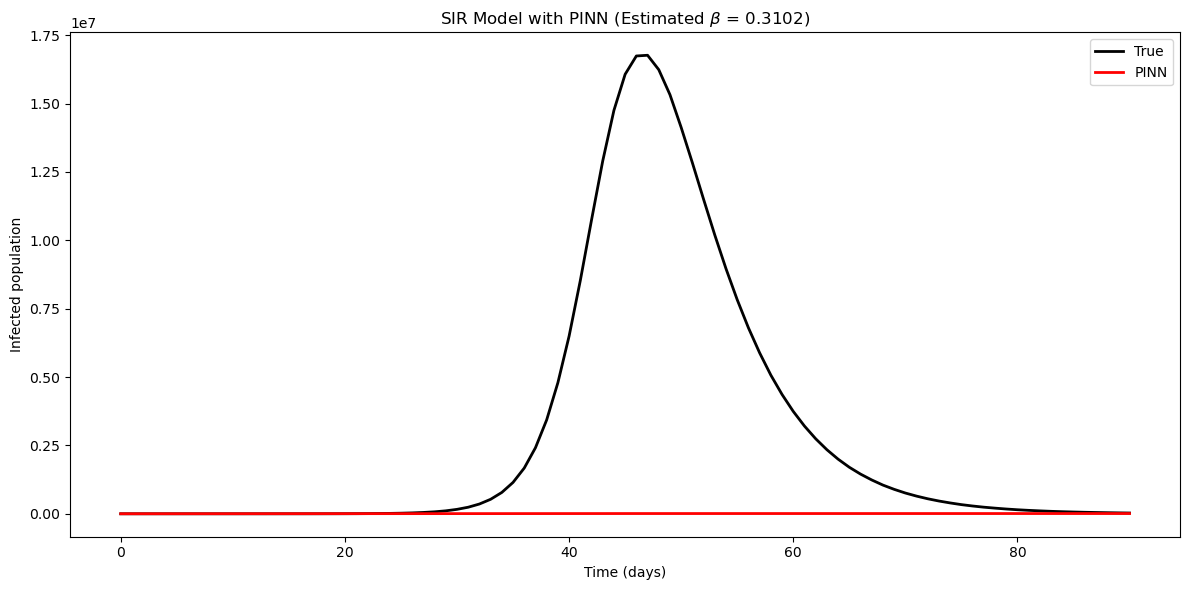

In [116]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=t_obs, y=i_obs, label='True', color='black', linewidth=2)
sns.lineplot(x=t_eval, y=pred_sir[:, 1], label='PINN', color='red', linewidth=2)

plt.xlabel('Time (days)')
plt.ylabel('Infected population')
plt.title(f'SIR Model with PINN (Estimated $\\beta$ = {pred_beta:.4f})')
plt.legend()
plt.tight_layout()
plt.show()

Beta evolution

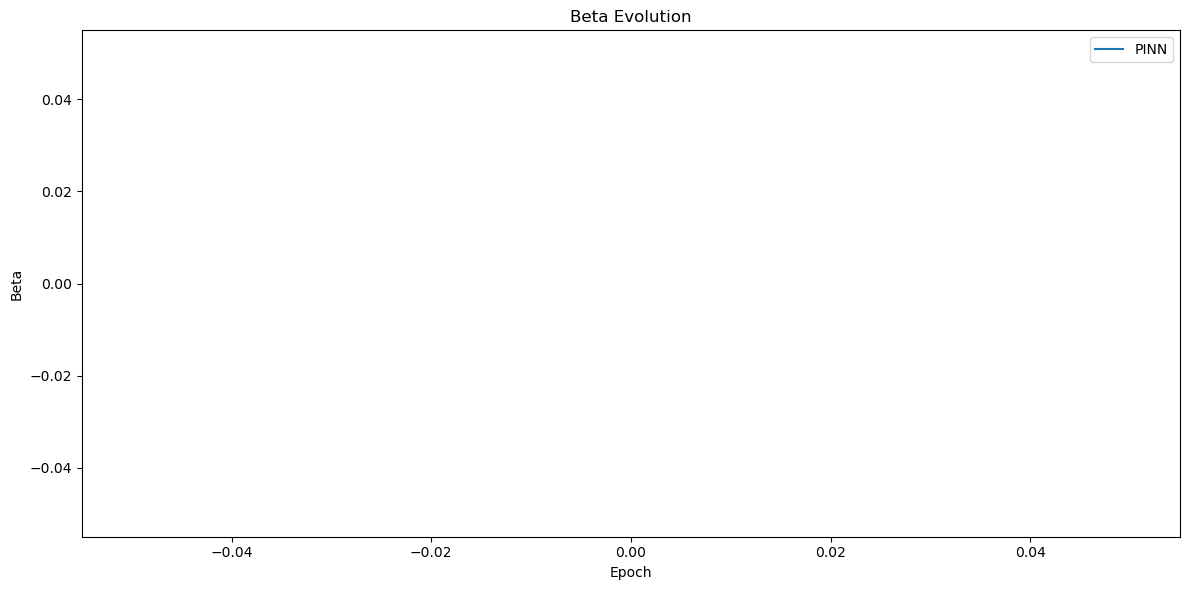

In [117]:
plt.figure(figsize=(12, 6))
plt.plot(model.beta_history, label='PINN')
plt.xlabel('Epoch')
plt.ylabel('Beta')
plt.title('Beta Evolution')
plt.legend()
plt.tight_layout()
plt.show()